<a href="https://colab.research.google.com/github/hlxabcd/hlxabcd.github.io/blob/master/sketcher/Sketcher_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

# Get the Class names 

In [28]:
!wget 'https://raw.githubusercontent.com/hlxabcd/hlxabcd.github.io/master/sketcher/class_names.txt'

--2019-03-19 13:40:00--  https://raw.githubusercontent.com/hlxabcd/hlxabcd.github.io/master/sketcher/class_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2790 (2.7K) [text/plain]
Saving to: ‘class_names.txt.4’

class_names.txt.4   100%[===================>]   2.72K  --.-KB/s    in 0s      

2019-03-19 13:40:01 (56.6 MB/s) - ‘class_names.txt.4’ saved [2790/2790]



Read the classes names 

In [0]:
f = open("class_names.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [0]:
!mkdir data

In [0]:
import urllib.request
import os
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    if not os.path.exists('data/' + c + '.npy'):
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download() 

# Imports 

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# 分割npy库提高加载效率

In [0]:
def split_dataset(root,target,max_items_per_class= 1000 ):
     all_files = glob.glob(os.path.join(root, '*.npy'))
     for idx, file in enumerate(all_files):
        print("process npy:",idx,file)
        data = np.load(file)
        # npy长度
        dataset_len = len(data)
        start = 0
        end = max_items_per_class
        num = 1
        fileName = file.split('/')[1].split('.')[0]
        # 按max_items_per_class分割npy文件
        while (start < dataset_len):
            resultData = data[start: end, :]
            # 分割后的文件命名
            targetFile = os.path.join(target, fileName+'_'+str(num)+'.npy');
            if not os.path.exists(targetFile):
              np.save(targetFile, resultData)
            num+=1
            start+=max_items_per_class
            end+=max_items_per_class


In [0]:
# 分割npy
#!mkdir data_process2
#split_dataset('data','data_process2')

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 2000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        print(idx,file)
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

import time
import datetime


  
def load_data_process(root, data_process_num, vfold_ratio=0.2):
    all_files = glob.glob(os.path.join(root, '*_'+str(data_process_num)+'.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []
    print("allfile:",len(all_files))
    #load each data file 
    for idx, file in enumerate(all_files):
        
        t = time.time()
        data = np.load(file)
        a = time.time()-t
        print('a:',a)
        labels = np.full(data.shape[0], idx)
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
        b = time.time()-t
        print('b:',b)
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

        c = time.time()-t
        print('c:',c)
        
    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
# class数量
num_classes=345
image_size = 28

# 准备model

allfile: 345
a: 0.001317739486694336
b: 0.006994009017944336
c: 0.0071277618408203125
a: 0.0018863677978515625
b: 0.015592336654663086
c: 0.015770912170410156
a: 0.0021164417266845703
b: 0.023138046264648438
c: 0.02372121810913086
a: 0.002078533172607422
b: 0.01623678207397461
c: 0.01641845703125
a: 0.0017075538635253906
b: 0.022182703018188477
c: 0.022748470306396484
a: 0.0020885467529296875
b: 0.04616880416870117
c: 0.046777963638305664
a: 0.001837015151977539
b: 0.05702996253967285
c: 0.05765700340270996
a: 0.0018291473388671875
b: 0.06621670722961426
c: 0.06691145896911621
a: 0.0021638870239257812
b: 0.017876386642456055
c: 0.018460750579833984
a: 0.0019638538360595703
b: 0.01761007308959961
c: 0.018201828002929688
a: 0.002115011215209961
b: 0.018523693084716797
c: 0.01913762092590332
a: 0.002225160598754883
b: 0.0209958553314209
c: 0.02120804786682129
a: 0.002222299575805664
b: 0.0329282283782959
c: 0.03360152244567871
a: 0.002126455307006836
b: 0.024205684661865234
c: 0.024881124

AttributeError: ignored

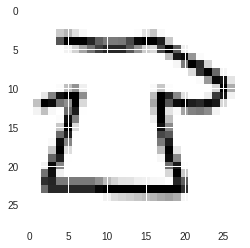

In [84]:
#x_train, y_train, x_test, y_test, class_names = load_data('data')
#num_classes = len(class_names)
#print(len(x_train))
data_process_count=2
count=1
while(count<=data_process_count):
  # load
  x_train, y_train, x_test, y_test, class_names = load_data_process('data_process2',count)
  num_classes = len(class_names)

  # show random data
  import matplotlib.pyplot as plt
  from random import randint
  %matplotlib inline  
  idx = randint(0, len(x_train))
  plt.imshow(x_train[idx].reshape(28,28)) 
  print(class_names[int(y_train[idx].item())])
    
  # Reshape and normalize
  x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')/255.0
  x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')/255.0

  # Convert class vectors to class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  
  if count==1:
  # Define model
    model = keras.Sequential()
    model.add(layers.Convolution2D(16, (3, 3),
                            padding='same',
                            input_shape=x_train.shape[1:], activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
    model.add(layers.MaxPooling2D(pool_size =(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax')) 
    # Train model
    adam = tf.train.AdamOptimizer()
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['top_k_categorical_accuracy'])
    print(model.summary())
  
  model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))


# Training 

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

# Testing 

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

# Inference 

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [0]:
!pip install tensorflowjs 

# Save and Convert 

In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [0]:
!cp class_names.txt model/class_names.txt

In [0]:
!zip -r model.zip model 

In [0]:
from google.colab import files
files.download('model.zip')